In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\Sanchit Dakle\OneDrive\Desktop\Excelar\exchange_rate.csv", parse_dates=['date'], index_col='date')
df

,Ex_rate
date,
01-01-1990 00:00,0.785500
02-01-1990 00:00,0.781800
03-01-1990 00:00,0.786700
04-01-1990 00:00,0.786000
05-01-1990 00:00,0.784900
...,...
06-10-2010 00:00,0.718494
07-10-2010 00:00,0.721839
08-10-2010 00:00,0.723197


In [3]:
ts = df['Ex_rate']


In [4]:
#adf_test(ts, 'Original Time Series')


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set_style('whitegrid')

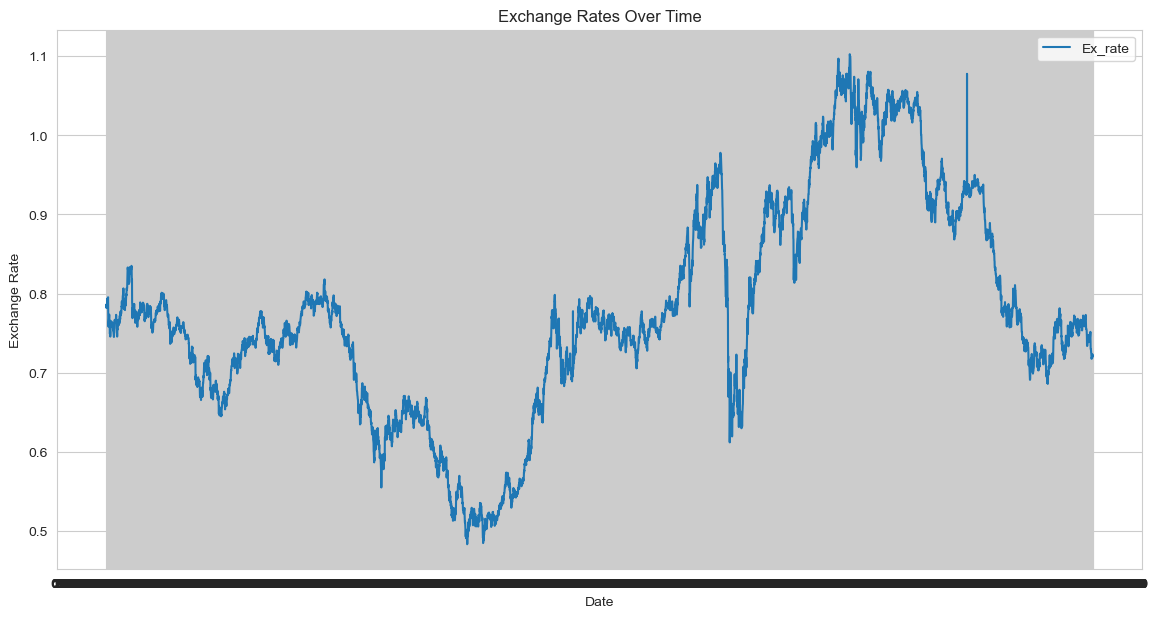

In [7]:
plt.figure(figsize=(14, 7))
for column in df.columns:
  plt.plot(df.index,df[column],label=column)
  plt.title('Exchange Rates Over Time')
  plt.xlabel('Date')
  plt.ylabel('Exchange Rate')
  plt.legend()
  plt.show()

# Data preprocessing

In [9]:
# find missing value
df.isnull().sum()

Ex_rate    0
dtype: int64

In [10]:
# fill value using forward fill
df.fillna(method='ffill',inplace=True)


C:\Users\Sanchit Dakle\AppData\Local\Temp\ipykernel_14888\389065689.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill',inplace=True)


In [11]:
from scipy import stats
import numpy as np

currency = 'Ex_rate'
z_scores = np.abs(stats.zscore(df[currency]))
threshold = 3
df_clean = df[z_scores < threshold]

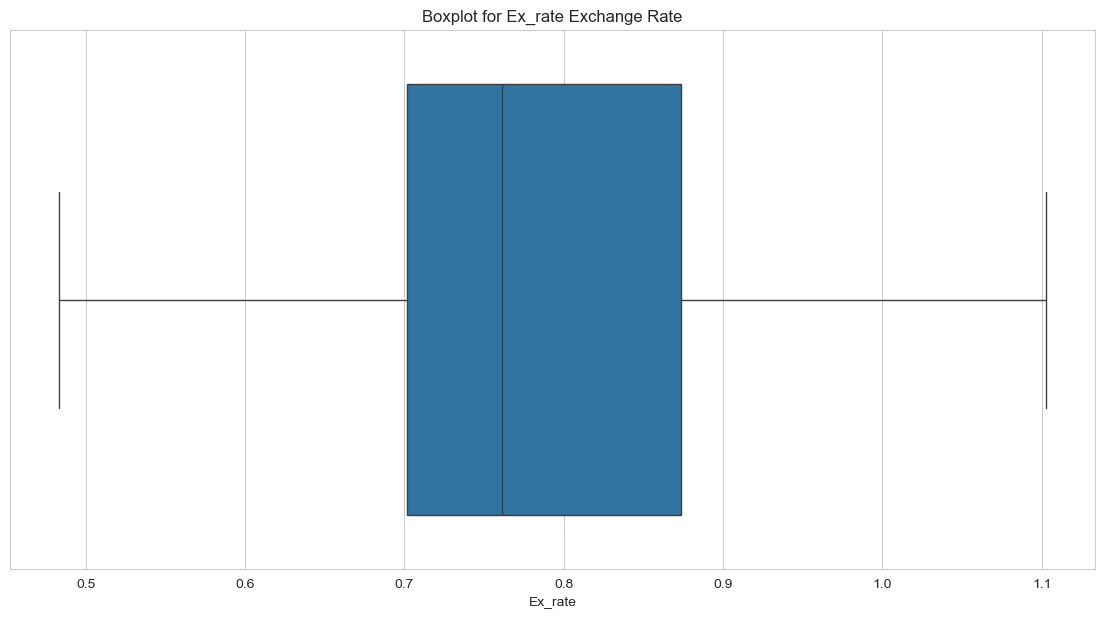

In [12]:
# visualize and handle anomalies manually
plt.figure(figsize=(14, 7))
sns.boxplot(x=df_clean[currency])
plt.title(f'Boxplot for {currency} Exchange Rate')
plt.show()

# Part 2: Model Building - ARIMA

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
currency = 'Ex_rate'

<Figure size 1400x700 with 0 Axes>

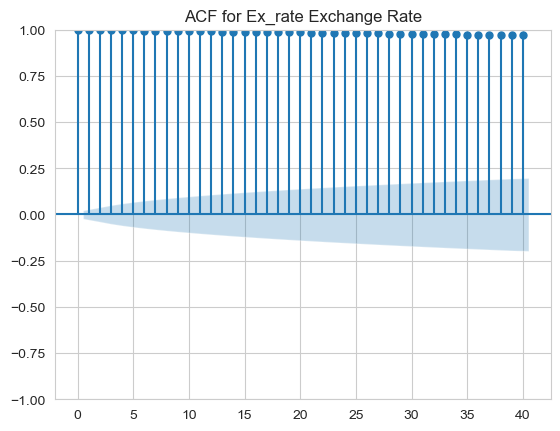

<Figure size 1400x700 with 0 Axes>

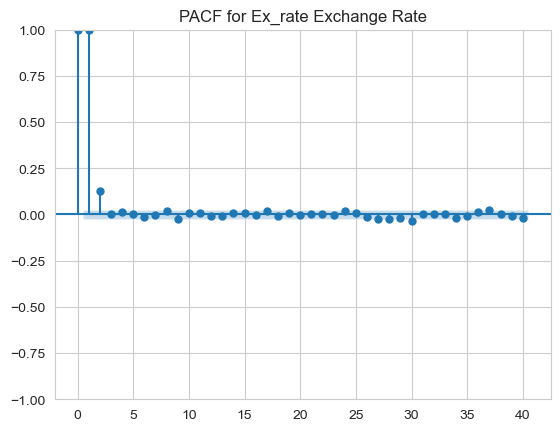

In [16]:
plt.figure(figsize=(14, 7))
plot_acf(df_clean[currency], lags=40)
plt.title(f'ACF for {currency} Exchange Rate')
plt.figure(figsize=(14, 7))
plot_pacf(df_clean[currency], lags=40)
plt.title(f'PACF for {currency} Exchange Rate')
plt.show()


In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna()) # result is defined here
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result[:4], labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05: 
        print("=> Stationary")
    else:
        print("=> Non-Stationary")
        

In [19]:
# perform adf test
adf_test(ts)

Augmented Dickey-Fuller Test: 
ADF Test Statistic: -1.664994180738073
p-value: 0.44923273535983155
#Lags Used: 1
Number of Observations Used: 7586
=> Non-Stationary


In [20]:
ts_diff = ts.diff().dropna()  # Differencing to make the series stationary


In [21]:
adf_test(ts_diff, 'Differenced Time Series')


Augmented Dickey-Fuller Test: Differenced Time Series
ADF Test Statistic: -99.39343120118626
p-value: 0.0
#Lags Used: 0
Number of Observations Used: 7586
=> Stationary


<Figure size 1400x600 with 0 Axes>

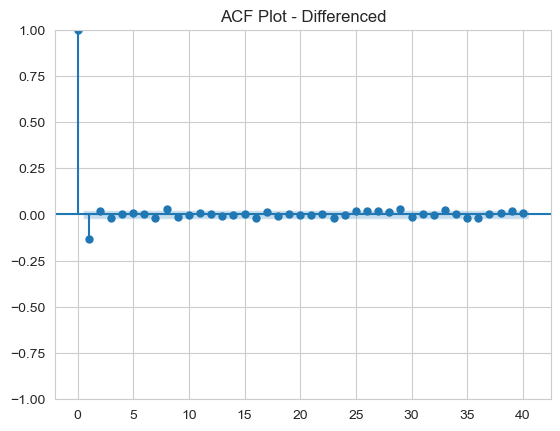

In [22]:
plt.figure(figsize=(14, 6))
plot_acf(ts_diff, lags=40)
plt.title('ACF Plot - Differenced')
plt.show()

<Figure size 1400x600 with 0 Axes>

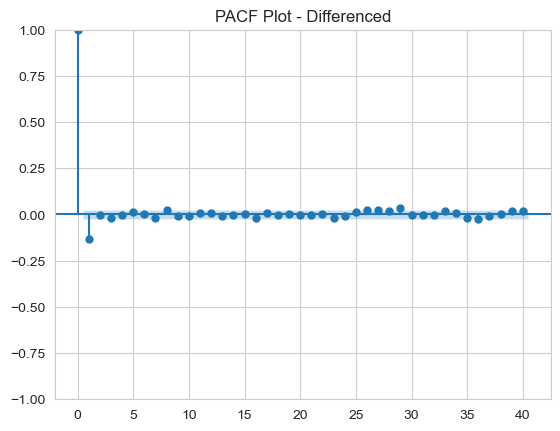

In [23]:
plt.figure(figsize=(14, 6))
plot_pacf(ts_diff, lags=40, method='ywm')
plt.title('PACF Plot - Differenced')
plt.show()

#2. Model Fitting


In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
# Define ARIMA model parameters
p = 1  # from PACF
d = 1  # first differencing
q = 1  # from ACF


In [27]:
# fit the model
model = ARIMA(ts, order=(p, d, q))
model_fit = model.fit()

C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [28]:
# model summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 04 Oct 2024   AIC                         -56102.322
Time:                        23:39:32   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.608      0.000    3.58e-05    3.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2865078.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 3. Diagnostics

In [30]:
# plot residual
residuals = model_fit.resid

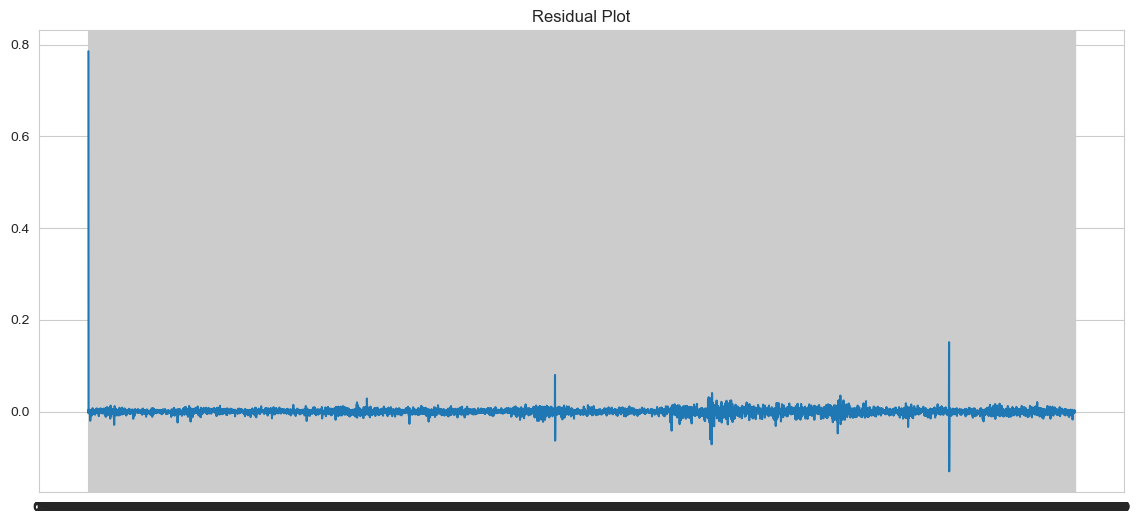

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(residuals)
plt.title('Residual Plot')
plt.show()

<Figure size 1400x600 with 0 Axes>

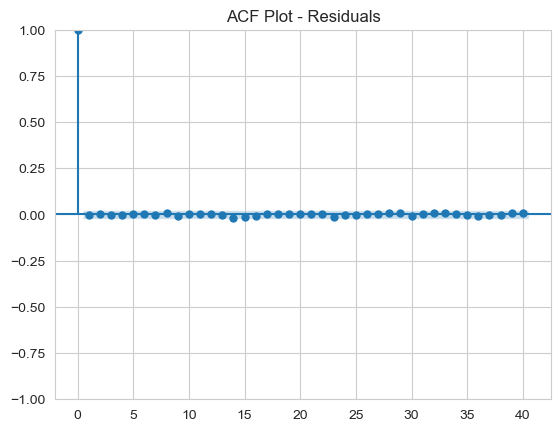

In [32]:
# Acf of residuals
plt.figure(figsize=(14, 6))
plot_acf(residuals, lags=40)
plt.title('ACF Plot - Residuals')
plt.show()

In [33]:
# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox


In [34]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

    lb_stat  lb_pvalue
10  1.81673   0.997562


# 4. Forecasting

In [36]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

In [37]:
# Fit ARIMA on training data
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [38]:
# Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = test.index


C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


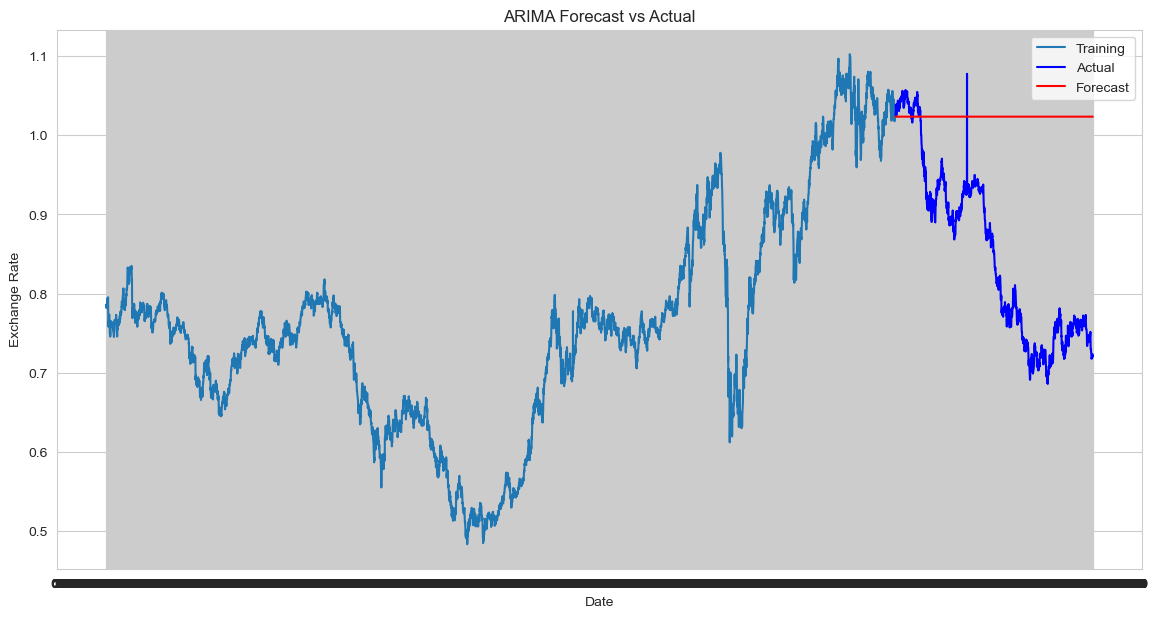

In [39]:
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Part 3: Model Building - Exponential Smoothing

In [41]:
# model selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

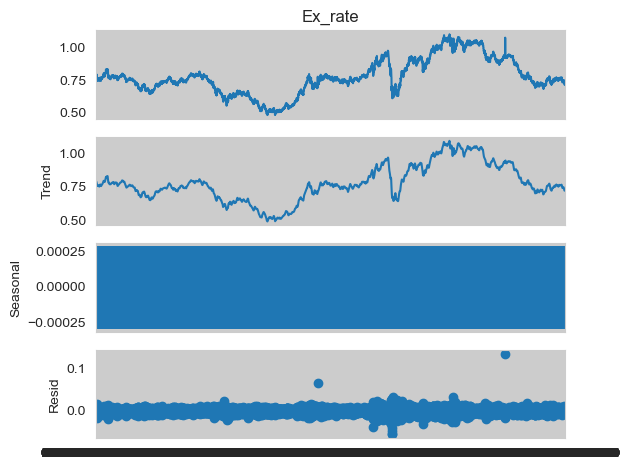

In [42]:
# Visual inspection suggests trend; check for seasonality
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()

# 2. Parameter Optimization

In [44]:
import itertools


In [45]:
# Define possible parameters
trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = [12]

In [46]:
# Grid search for best parameters based on AIC
best_aic = float('inf')
best_params = None
best_model = None


In [47]:
for trend in trend_options:
    for seasonal in seasonal_options:
        for period in seasonal_periods:
            if seasonal is None and trend is None:
                continue  # At least one component should be present
            try:
                model = ExponentialSmoothing(ts, trend=trend, seasonal=seasonal, seasonal_periods=period)
                model_fit = model.fit(optimized=True)
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_params = (trend, seasonal, period)
                    best_model = model_fit
            except Exception as e:
                continue

C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will b

In [48]:
print(f'Best Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}, Period={best_params[2]}')
print(f'Best AIC: {best_aic}')

Best Parameters: Trend=mul, Seasonal=None, Period=12
Best AIC: -77641.16854379718


# 3. Model Fitting and Forecasting

In [50]:
# Split into training and test sets
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

In [51]:
# Fit the model on training data
model = ExponentialSmoothing(train, trend=best_params[0], seasonal=best_params[1],
seasonal_periods=best_params[2])
model_fit = model.fit(optimized=True)

C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [52]:
# Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Sanchit Dakle\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Plot actual vs forecast
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='green')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Part 4: Evaluation and Comparison


In [ ]:
#1. Compute Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
def calculate_metrics(actual, forecast):
    pass
    mae = mean_absolute_error(actual, forecast)
    rmse = mean_squared_error(actual, forecast, squared=False)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, rmse, mape

In [ ]:
# ARIMA Metrics
#Fit the model
fit = model.fit()
#Generate the predictions
#forecast_es = fit.predict(start=0, end=len(test) - 1)
forecast_es = fit.predict(start=0, end=len(test) - 1)



In [ ]:
arima_mae, arima_rmse, arima_mape = calculate_metrics(test, forecast_es)


In [ ]:
# Exponential Smoothing Metrics
es_mae, es_rmse, es_mape = calculate_metrics(test, forecast_es)

In [ ]:
# Display Metrics
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [arima_mae, es_mae],
    'RMSE': [arima_rmse, es_rmse],
    'MAPE': [arima_mape, es_mape]
})

print(metrics_df)